---
title: 推荐系统笔记 1 -- LFM 算法
tags: 小书匠,mf,Recommender|推荐系统
grammar_cjkRuby: true
# renderNumberedHeading: true
---

[toc!]

# 推荐系统笔记 1 -- LFM 算法

## 理论

Matrix Factorization 是一种比较传统的推荐算法。

矩阵分解有许多种算法。这里介绍的是一种在推荐系统中常见的算法 LFM（latent factor model）


基于矩阵分解进行用户推荐的思想是填补用户的评分矩阵。

假设目前有用户的评分矩阵 $R \in R^{n \times m}$ ，横向代表用户，纵向代表物品


LFM 认为, 用户和物品可以分别被一个 k 维的 latent factor 表示. 记用户 i  对应的隐向量为 $u_i \in R^k$ , 记物品 j 对应的隐向量为 $v_j \in R^k$ ,则LFM模型认为, 用户 i 对于物品 j 的打分为 $u_i \cdot v_j$ .

记 $S = \{(i, j) | \text{用户 i 给物品 j 打过分} \}$

loss 取为 

$$
L = \sum_{(i,j) \in S} (R_{ij} - U_iV_j^T)^2 + \lambda \left( \sum_{i=1}^{n} \| U_i \|^2_2   + \sum_{j=1}^{m} \| V_j \|_2^2 \right)
$$

这个实际是就是 mse 加了正则项

求梯度

$$
\begin{aligned}
    \frac{\partial L}{\partial U_i} &= - 2 ( R_{ij} - U_iV_j^T )  V_j  + 2 U_i \\ 
    \frac{\partial L}{\partial V_j} &= - 2 ( R_{ij} - U_iV_j^T )  U_i  + 2 V_j
.\end{aligned}
$$ 

因此可以使用 梯度下降来解决这个问题。

## 实现

### 基于 Numpy 的实现

#### 1. 导入必要的包并进行数据准备

In [6]:
import numpy as np
from matplotlib import pyplot as plt

R = np.array([[5, 5, 0, 5], [5, 0, 3, 4], [3, 4, 0, 3], [0, 0, 5, 3],
              [5, 4, 4, 5], [5, 4, 5, 5]])

n = 6 # 用户数
m = 4 # 物品数
k = 3 # 隐向量的维数
np.random.seed(123)
U = np.random.randn(n, k)
V = np.random.randn(m, k)

#### 2. 定义 loss

In [7]:
def loss(R, U, V, lambda_=0.01):
    mask = R > 0
    l = ((R - np.matmul(U, V.T))**2 * mask).sum()
    l += lambda_ * np.linalg.norm(U)
    l += lambda_ * np.linalg.norm(V)
    return l

#### 3. 定义参数更新步骤

In [8]:
def update(R, U, V, lr=0.02, lambda_=0.01):
    nrow, ncol = R.shape[0], R.shape[1]
    for i in range(nrow):
        for j in range(ncol):
            if R[i][j] != 0:
                error = R[i][j] - np.dot(U[i], V[j])
                dui = -2 * error * V[j] + 2 * lambda_ * U[i]
                dvj = -2 * error * U[i] + 2 * lambda_ * V[j]
                U[i] -= lr * dui
                V[j] -= lr * dvj

#### 4. 训练并打印结果

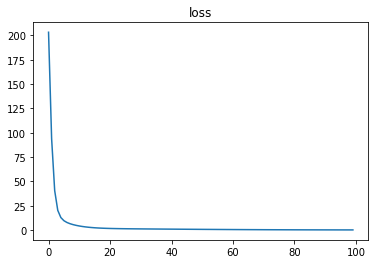

用户隐向量 U:  [[-1.04568902  0.12687525  2.23828397]
 [-0.19355381  0.08477336  2.08792848]
 [-0.7077599  -1.12493478  1.41477264]
 [-2.08515214 -1.05210444  0.91756449]
 [-0.87329857  0.81976993  2.13159532]
 [-1.35773196  1.14384416  2.11048642]]
物品隐向量 V:  [[ 0.19686727  0.19309862  2.36530044]
 [-0.19152379 -0.72516055  2.14070428]
 [-1.78347324 -0.11144921  1.24702352]
 [-0.67795314  0.14087865  1.89789664]]
实际数据阵:  [[5 5 0 5]
 [5 0 3 4]
 [3 4 0 3]
 [0 0 5 3]
 [5 4 4 5]
 [5 4 5 5]]
预测数据阵:  [[5.11285155 4.89977347 4.64201099 4.97483379]
 [4.91684334 4.44523329 2.93944604 4.10583561]
 [2.98980422 3.97992101 3.15189868 3.00644098]
 [1.55665757 3.1265351  4.98029375 3.00685895]
 [5.02823588 4.13590786 4.12429142 4.75309118]
 [4.94551619 3.94849462 4.92582429 5.08710694]]


In [9]:
loss_list = []
n_epochs = 100
for epoch in range(n_epochs):
    update(R, U, V)
    loss_list.append(loss(R, U, V))

plt.plot(loss_list)
plt.title("loss")
plt.show()

print("用户隐向量 U: ", U)
print("物品隐向量 V: ", V)
print("实际数据阵: ", R)
print("预测数据阵: ", np.matmul(U, V.T))

### 基于 Tensorflow 的实现

2.1.0


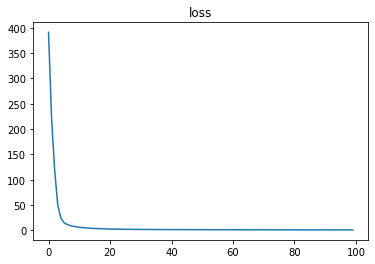

<tf.Variable 'Variable:0' shape=(6, 3) dtype=float32, numpy=
array([[-1.1320447 ,  0.3901746 ,  2.2369921 ],
       [-0.48116514,  0.05242732,  2.112321  ],
       [-0.6934797 , -1.211695  ,  1.402821  ],
       [-2.1680768 , -1.2164221 ,  0.6541038 ],
       [-1.1313654 ,  0.78087276,  2.0872607 ],
       [-1.5207676 ,  1.34338   ,  2.1233516 ]], dtype=float32)>
<tf.Variable 'Variable:0' shape=(4, 3) dtype=float32, numpy=
array([[ 0.1458859 ,  0.16502438,  2.356139  ],
       [ 0.17939557, -0.64301574,  2.3745816 ],
       [-1.9784566 , -0.06871409,  0.9401924 ],
       [-0.89302886,  0.06262701,  1.7542328 ]], dtype=float32)>
tf.Tensor(
[[5. 5. 0. 5.]
 [5. 0. 3. 4.]
 [3. 4. 0. 3.]
 [0. 0. 5. 3.]
 [5. 4. 4. 5.]
 [5. 4. 5. 5.]], shape=(6, 4), dtype=float32)
tf.Tensor(
[[5.1699033 4.857948  4.316094  4.959589 ]
 [4.915378  4.895848  2.93435   4.13848  ]
 [3.004113  3.9858446 2.7742016 3.004287 ]
 [1.0241283 1.946458  4.9880147 3.0074246]
 [4.881689  4.2512956 4.147127  4.720787 ]
 [5.00

In [10]:

import tensorflow as tf 
print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt

R = tf.constant([[5, 5, 0, 5], [5, 0, 3, 4], [3, 4, 0, 3], [0, 0, 5, 3],
              [5, 4, 4, 5], [5, 4, 5, 5]], dtype=tf.float32)

n = 6 # 用户数, R 的行数
m = 4 # 物品数，R 的列数
k = 3 # 隐向量的维数
lr = 0.02
np.random.seed(123)
U = tf.Variable(np.random.randn(n, k), dtype=tf.float32)
V = tf.Variable(np.random.randn(m, k), dtype=tf.float32)

def mse(R, U, V, lambda_=0.01):
    mask = R > 0 
    l = tf.reduce_sum(((R - tf.matmul(U, tf.transpose(V)))**2 * tf.cast(mask, tf.float32)))
    l += lambda_ * tf.linalg.norm(U)**2
    l += lambda_ * tf.linalg.norm(V)**2
    return l

optimizer = tf.keras.optimizers.SGD(
    learning_rate=lr, momentum=0.0, nesterov=False
)

n_epochs = 100
loss_list = []
for epoch in range(n_epochs):
    with tf.GradientTape() as tape:
        loss = mse(R, U, V)
    grads = tape.gradient(loss, [U, V])
    optimizer.apply_gradients(zip(grads, [U, V]))
    loss_list.append(loss.numpy())

# 打印loss的变化
plt.plot(loss_list)
plt.title('loss')
plt.show()

print(U)
print(V)
print(R)
print(tf.matmul(U, tf.transpose(V)))

# References
1. [推荐系统（2）—LFM（Latent Factor Model）模型 - 雁渡的寒潭 - 博客园](https://www.cnblogs.com/tbiiann/p/6535189.html)